In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
from numpy.linalg import matrix_power                  # This is to raise matrices to powers
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import pandas as pd
import scipy.signal as scy
import scipy.stats as stats
from scipy.stats import gaussian_kde

from sklearn.linear_model import LinearRegression
from Functions_autocorrelation_for___Analysis_of_entrainment_mode_hopping_chaos import *
from Functions_peak_to_peak_for___Analysis_of_entrainment_mode_hopping_chaos import *
%load_ext autoreload
%autoreload 2


plt.rcParams["font.family"] = "Arial"

# Load data, merge with parameters, smooth

In [2]:
file_path="Input_files/"
file_out_path = "Output_files/"
fig_path = "Figures/"
parameters = pd.read_csv(file_path+"Parameters.csv",index_col=0, delimiter=',',header=0)

dataset_dict = []
titles = parameters["filename"].tolist()
for n in np.arange(0,len(titles),1): #### Choose external frequency   
    # Load the data
    matrix_of_traces = np.array(pd.read_csv(file_path+"p53_from"+titles[n]+".txt", delimiter=',',header=None))
    for cell in range(matrix_of_traces.shape[0]):
        dataset_dict.append(
            {"filename": titles[n],
             "cell_id": cell, 
             "p53_trace":matrix_of_traces[cell,:]}
        )

In [3]:
dataset = pd.DataFrame(dataset_dict)
dataset = pd.merge(dataset,parameters, on = ["filename"], how = 'left')
dataset = dataset.apply(split_trajectories_in_3_zones,axis=1)
dataset = dataset.apply(compute_position_nutlin_pulses, axis=1)
dataset = dataset.apply(subtract_poly_fit, axis=1)
dataset = dataset.apply(smooth_filter_median, axis = 1)
dataset = dataset.apply(smooth_filter_polyn, axis = 1)
dataset.to_pickle(file_out_path+"Dataset.pkl")

## Data analysis

### With peak-to-peak distance

In [3]:
dataset = pd.read_pickle(file_out_path+"Dataset.pkl")
dataset = dataset.apply(compute_peaks, axis = 1)
dataset = dataset.apply(compute_peak_to_peak_distance, axis = 1)
dataset = dataset.apply(find_entrainment_type,axis=1)

In [4]:
dataset_grouped_by_entrain_label = group_df(dataset, "entrain_label")
dataset_grouped_by_entrain_label = dataset_grouped_by_entrain_label[["Entrained", 
                                                                   "Period-2",
                                                                   "Mode-hopping",
                                                                     "Unclassified"]]# Reorder columns
dataset_grouped_by_entrain_mode = group_df(dataset,"entrain_mode")

## Plots

TypeError: __init__() got an unexpected keyword argument 'font'

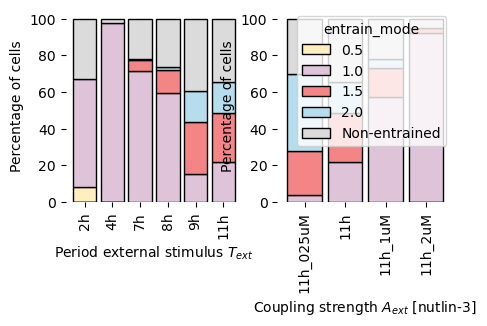

In [22]:
make_histo(dataset_grouped_by_entrain_mode,
           color_list =  ["#FFEEBF","#DFC3D8","#F48586", 
                                                          "#B5DDED","#DBDBDB"],
          filename_tosave = "Histo_entrain_mode") # "#C6E2B8"
make_histo(dataset_grouped_by_entrain_label,
           color_list = ["#DBDBDB","#F38713","#1B9AAA","#1B065E"],
          filename_tosave ="Histo_entrain_label")

### Check one cell in the dataset

In [606]:
cond1 = dataset["cell_id"]==12
cond2 = dataset["nutlin_period [hour]"]==11
subset = dataset.loc[cond1 & cond2].reset_index(drop=True)
pd.set_option('display.max_columns', None)
subset.head()

all_peaks  cell_id entrain_label  \
0  [78, 116, 142, 167, 205, 266, 301, 333, 366, 400]       12  Unclassified   
1     [8, 56, 80, 121, 147, 192, 220, 271, 338, 403]       12  Unclassified   
2   [11, 78, 120, 147, 214, 288, 322, 344, 412, 449]       12     Entrained   
3                  [13, 76, 141, 206, 271, 313, 343]       12     Entrained   

    entrain_mode                                      filename  \
0  Non-entrained  MP_2021_08_16_measurements_YFP_CFP_11h_025uM   
1  Non-entrained        MP_2021_04_17_measurements_YFP_CFP_11h   
2            1.5    MP_2021_08_11_measurements_YFP_CFP_11h_1uM   
3            1.0    MP_2020_12_04_measurements_YFP_CFP_11h_2uM   

   length_of_timeseries mode_hopping modes  nutlin_concentration [uM]  \
0                   862                NaN                       0.25   
1                   651                NaN                       0.50   
2                   741                NaN                       1.00   
3                   690                NaN                       2.00   

   nutlin_period [hour]  nutlin_pulses  \
0                  11.0              7   
1                  11.0              7   
2                  11.0              7   
3                  11.0              6   

                                           p53_trace  \
0  [746.012738853503, 556.484076433121, 344.26114...   
1  [2159.22929936306, 2195.63057324841, 2226.1401...   
2  [375.59872611465, 430.700636942675, 555.898089...   
3  [310.828025477707, 324.490445859873, 371.0, 43...   

                               peak_to_peak_distance  \
0  [38.0, 26.0, 25.0, 38.0, 61.0, 35.0, 32.0, 33....   
1  [48.0, 24.0, 41.0, 26.0, 45.0, 28.0, 51.0, 67....   
2  [67.0, 42.0, 27.0, 67.0, 74.0, 34.0, 22.0, 68....   
3                     [63.0, 65.0, 65.0, 65.0, 72.0]   

                                               peaks  \
0  [78, 116, 142, 167, 205, 266, 301, 333, 366, 400]   
1     [8, 56, 80, 121, 147, 192, 220, 271, 338, 403]   
2   [11, 78, 120, 147, 214, 288, 322, 344, 412, 449]   
3                       [13, 76, 141, 206, 271, 343]   

                                     peaks_amplitude  \
0  [97.45585495471963, 203.90441882435925, 428.79...   
1  [1050.0748603767167, 456.82238737624505, 1778....   
2  [517.1504839095318, 1064.8709137641129, 356.22...   
3  [246.97186723670887, 442.972804495093, 344.668...   

                                                  t1  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
1  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
2  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
3  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                                  t2  \
0  [94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 10...   
1  [99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105....   
2  [94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 10...   
3  [99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105....   

                                                  t3  \
0  [553.0, 554.0, 555.0, 556.0, 557.0, 558.0, 559...   
1  [558.0, 559.0, 560.0, 561.0, 562.0, 563.0, 564...   
2  [553.0, 554.0, 555.0, 556.0, 557.0, 558.0, 559...   
3  [492.0, 493.0, 494.0, 495.0, 496.0, 497.0, 498...   

                                                time  \
0  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
1  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
2  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   
3  [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...   

                                 time_nutlin_pulses  \
0  [93.0, 159.0, 225.0, 291.0, 357.0, 423.0, 489.0]   
1  [98.0, 164.0, 230.0, 296.0, 362.0, 428.0, 494.0]   
2  [93.0, 159.0, 225.0, 291.0, 357.0, 423.0, 489.0]   
3         [98.0, 164.0, 230.0, 296.0, 362.0, 428.0]   

                                      time_p53_peaks  toff  ton  \
0  [172.0, 210.0, 236.0, 261.0, 299.0, 360.0, 395...   522   93   
1  [107.0, 155.0, 179.0, 220.0, 246.0, 291.0, 319...   527   98   
2  [105.0, 172

### Check classification result

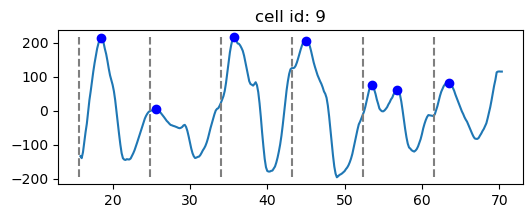

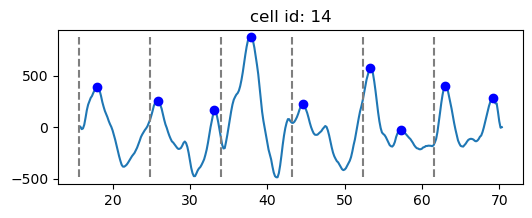

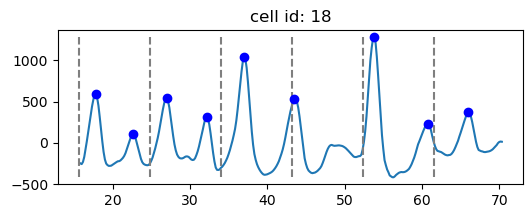

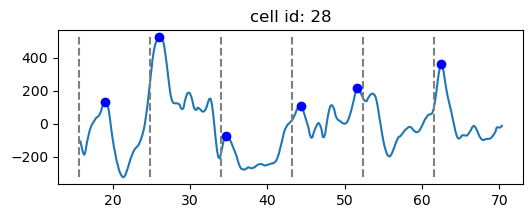

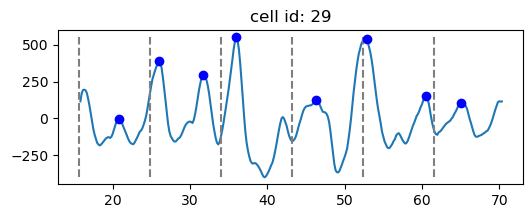

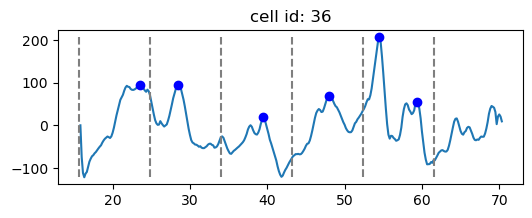

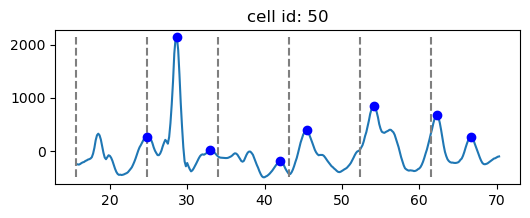

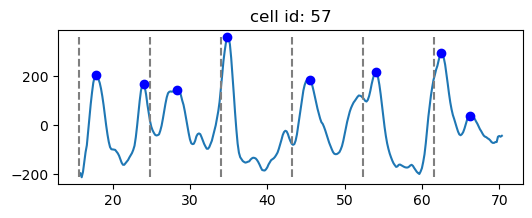

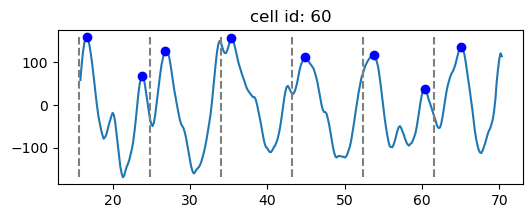

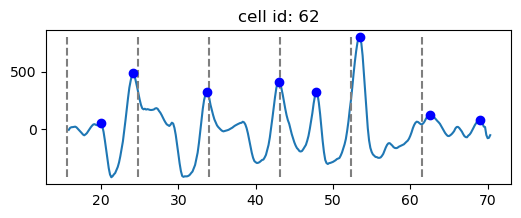

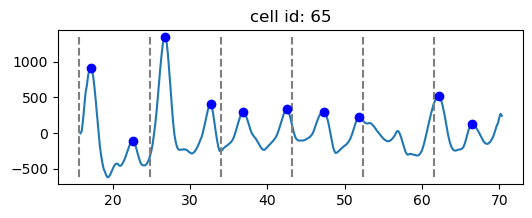

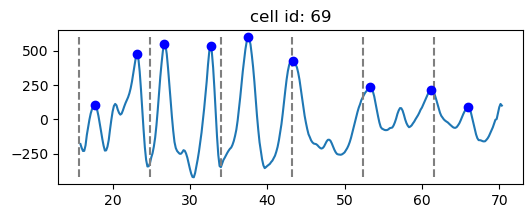

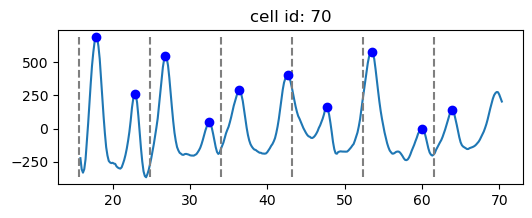

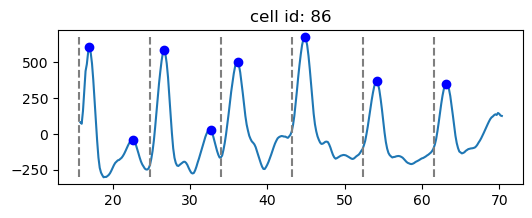

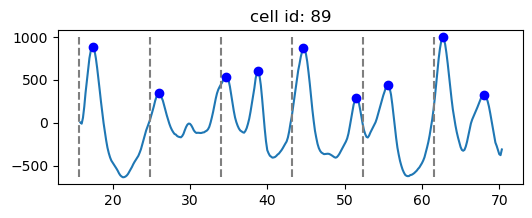

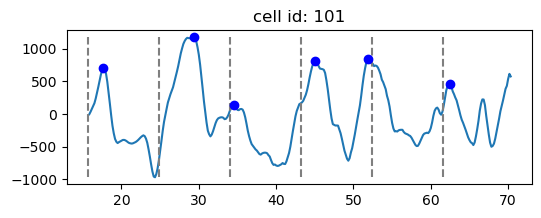

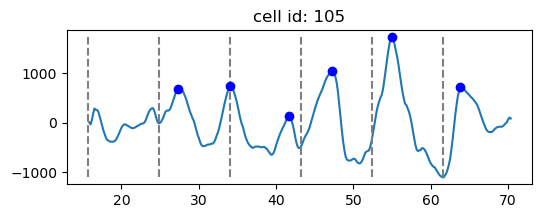

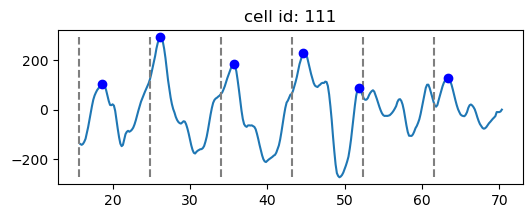

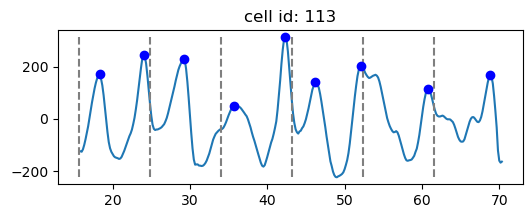

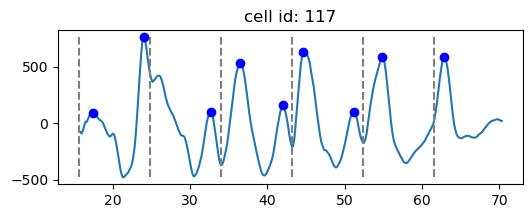

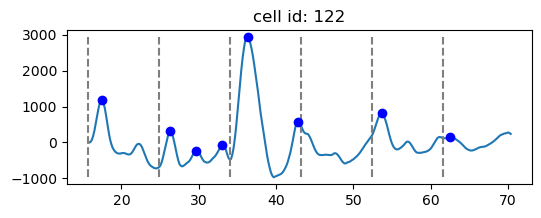

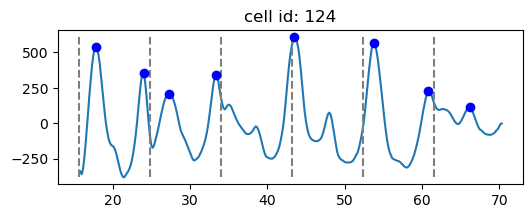

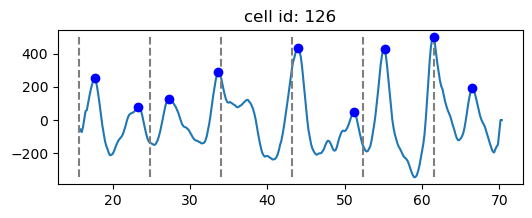

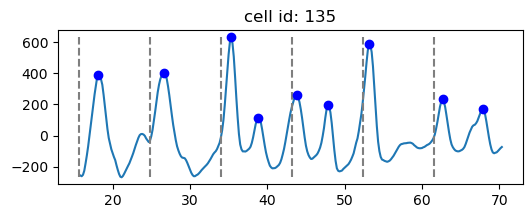

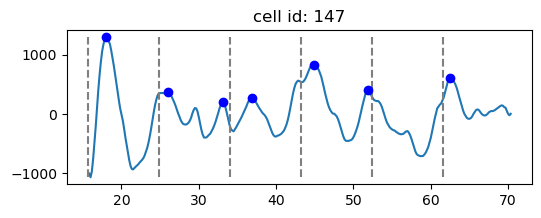

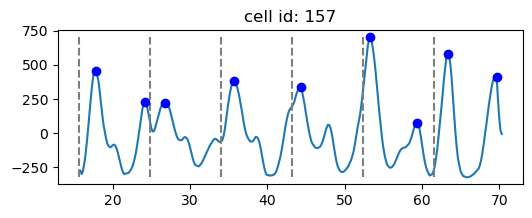

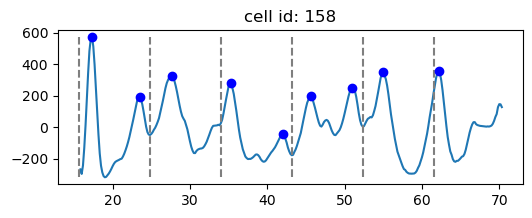

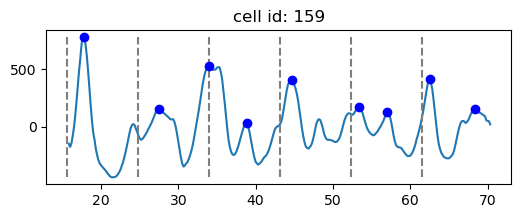

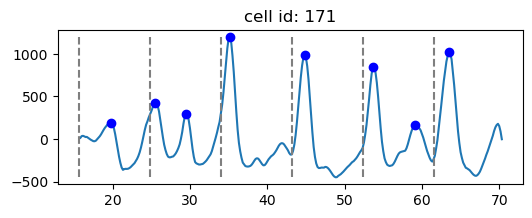

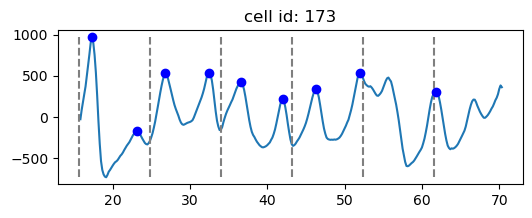

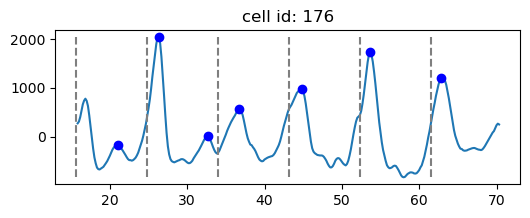

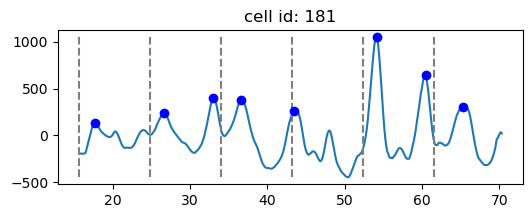

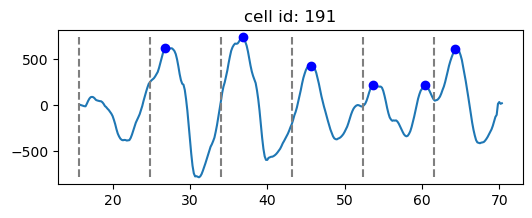

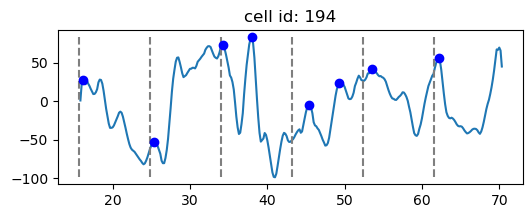

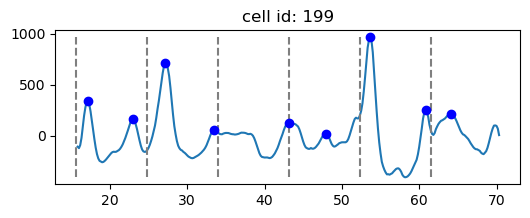

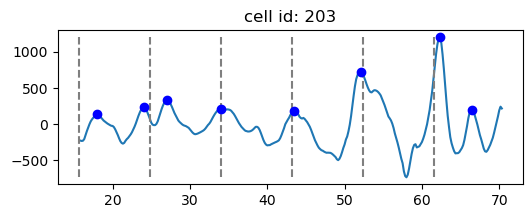

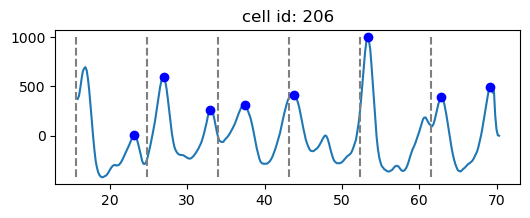

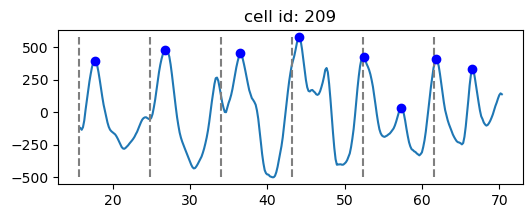

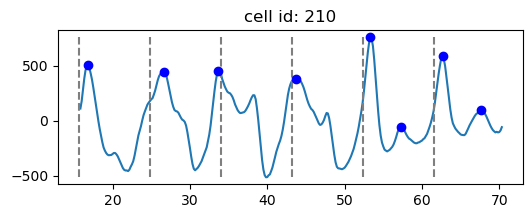

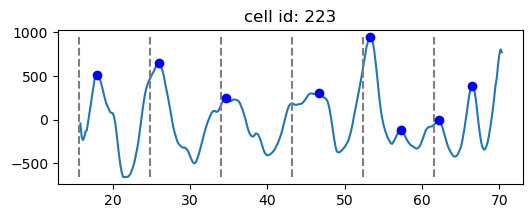

In [595]:
plot_single_cells(dataset, nut_period = 9.17, 
                  nut_conc = 0.5, 
                  smoothed_traces = True, 
                  entrain_label = "Mode-hopping", 
                  entrain_mode = "Non-entrained",
                  plotallpeaks = False)

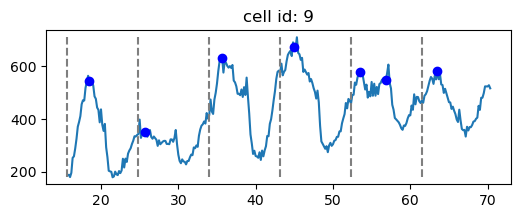

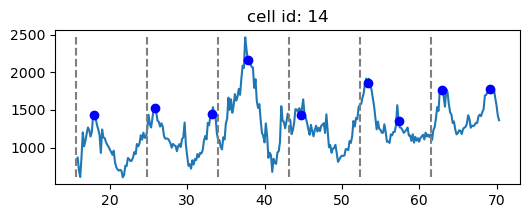

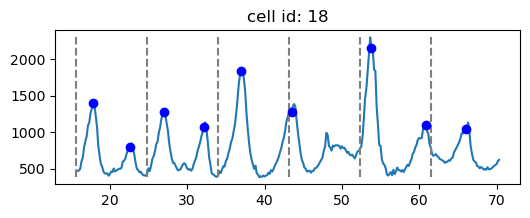

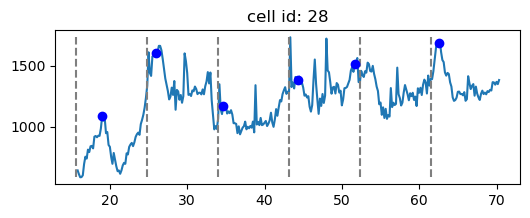

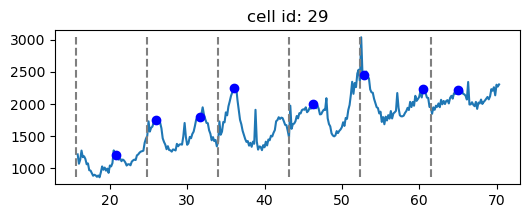

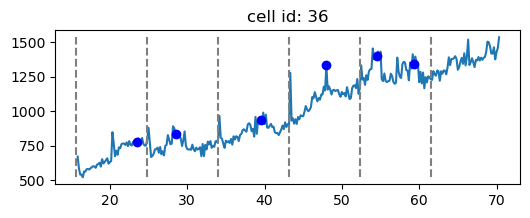

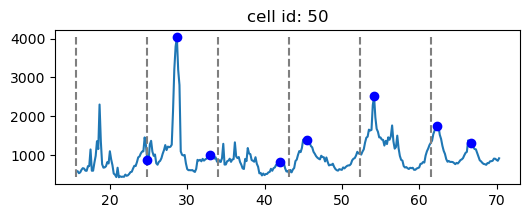

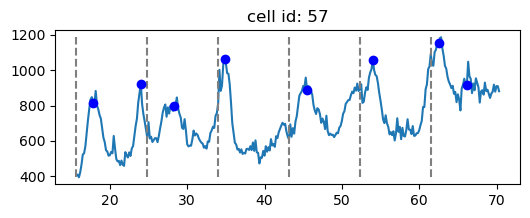

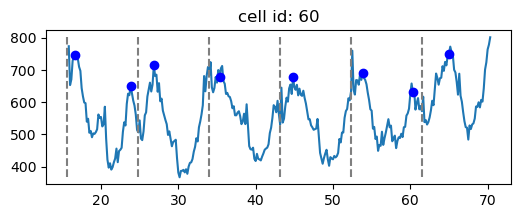

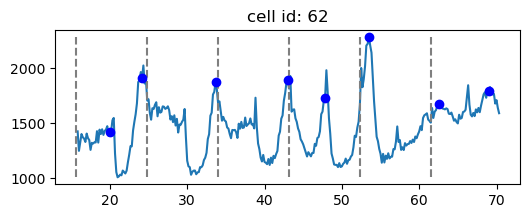

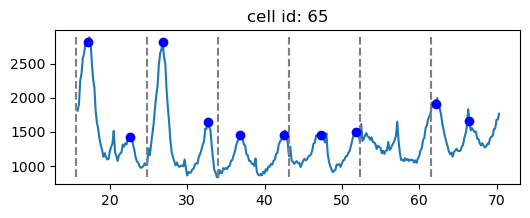

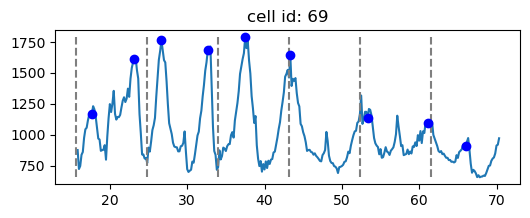

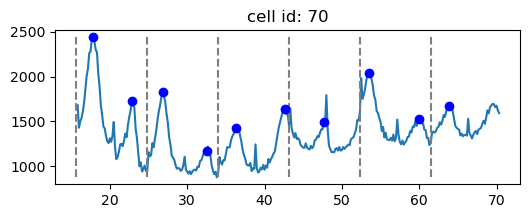

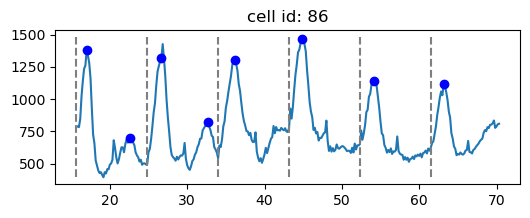

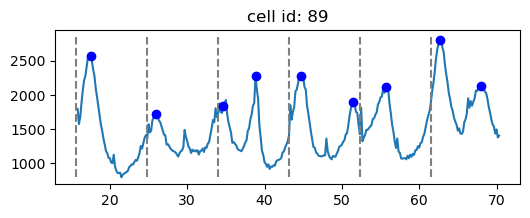

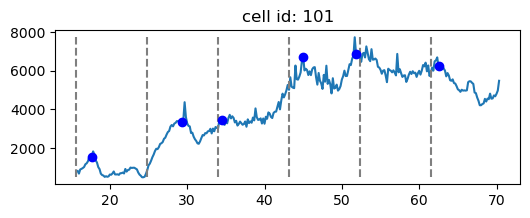

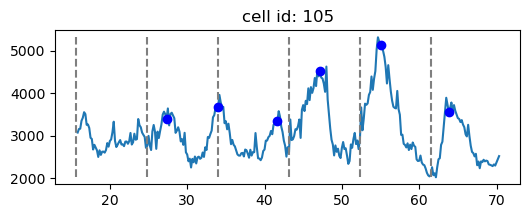

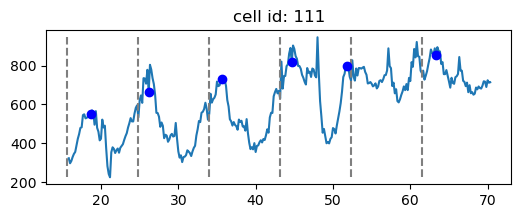

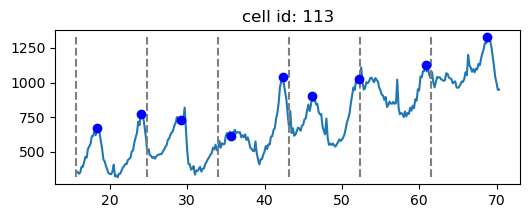

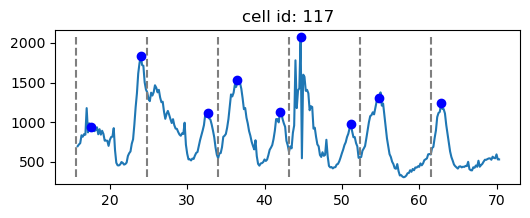

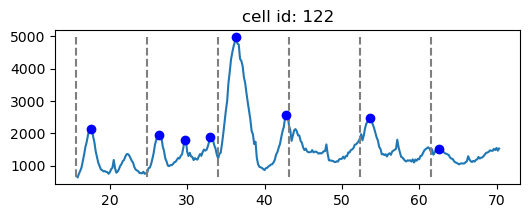

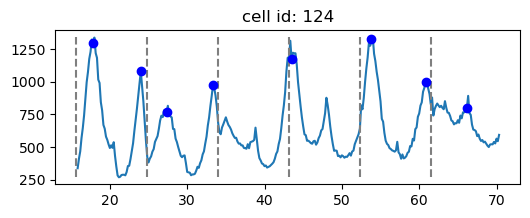

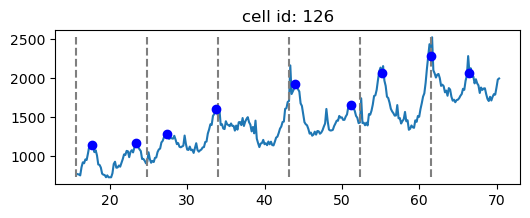

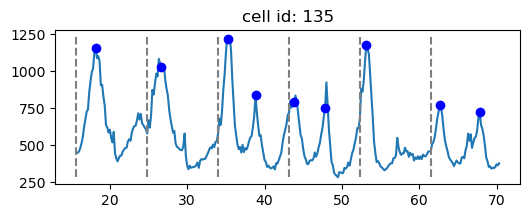

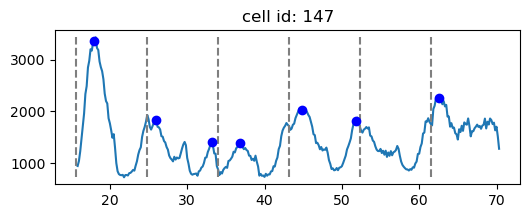

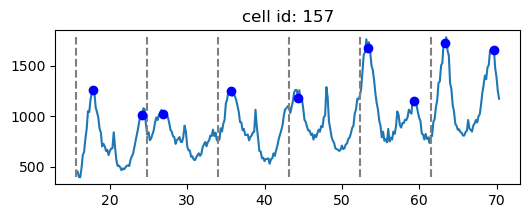

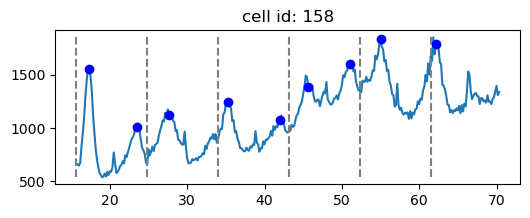

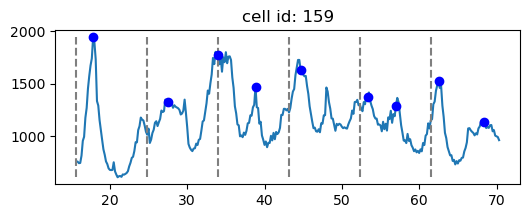

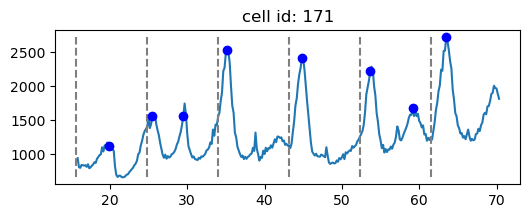

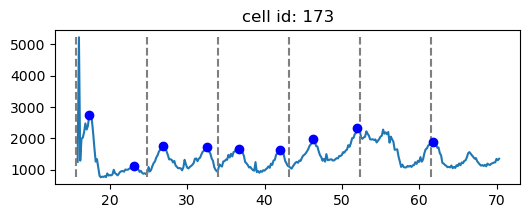

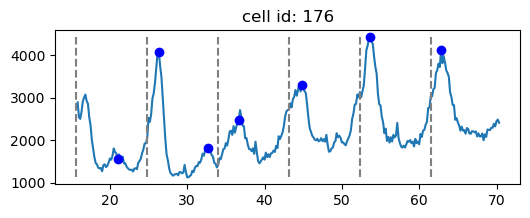

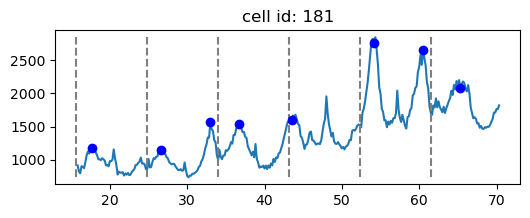

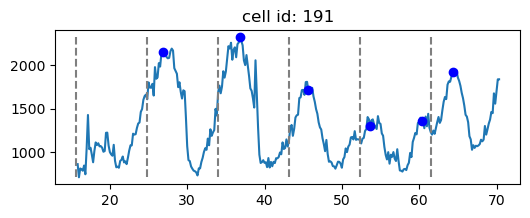

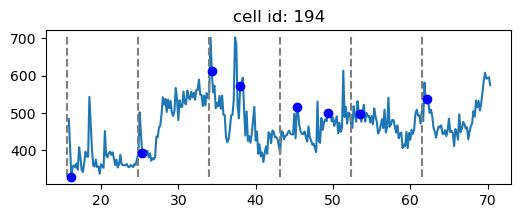

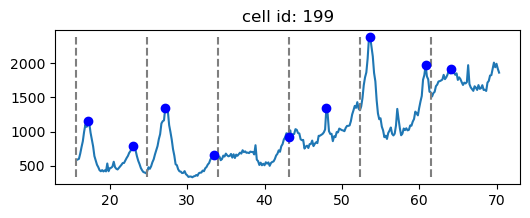

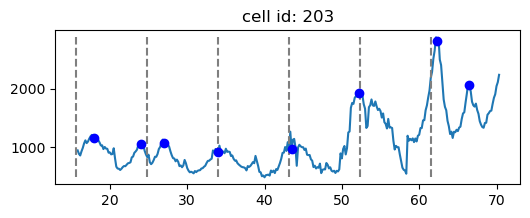

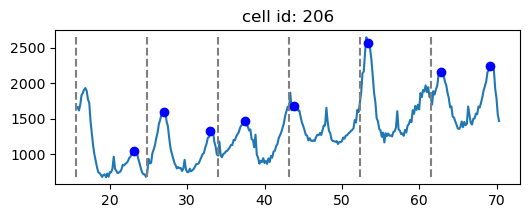

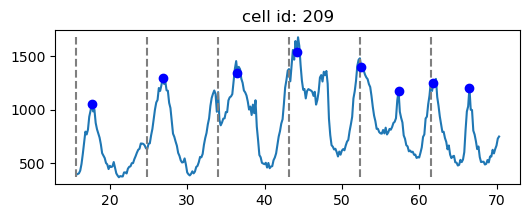

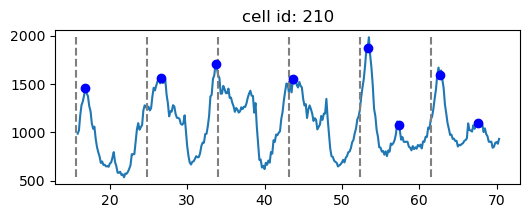

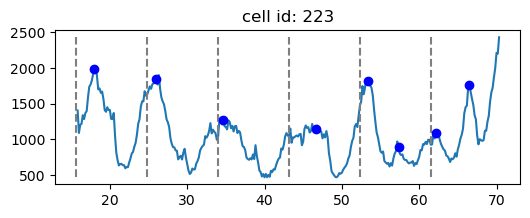

In [622]:
plot_single_cells(dataset, nut_period = 9.17, 
                  nut_conc = 0.5, 
                  smoothed_traces = False, 
                  entrain_label = "Mode-hopping", 
                  entrain_mode = "Non-entrained")

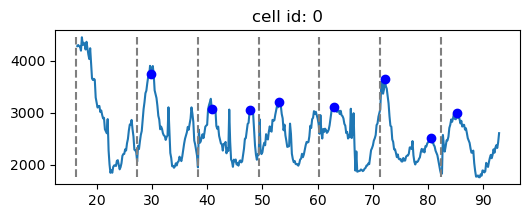

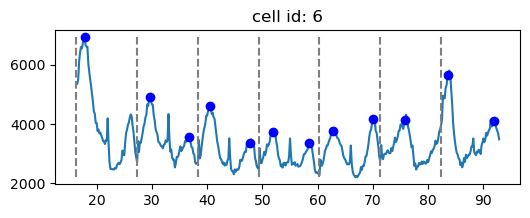

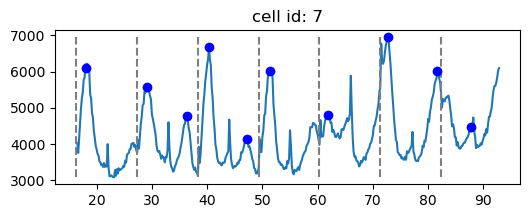

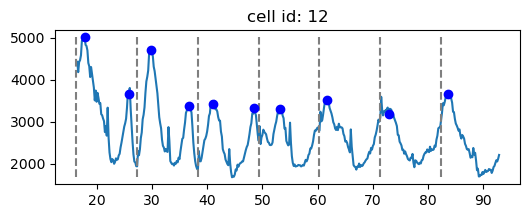

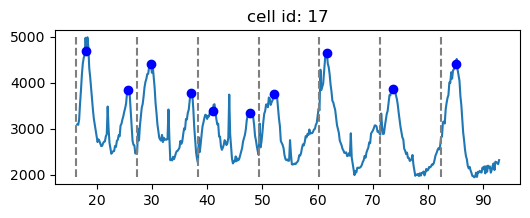

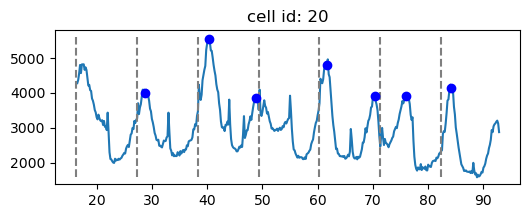

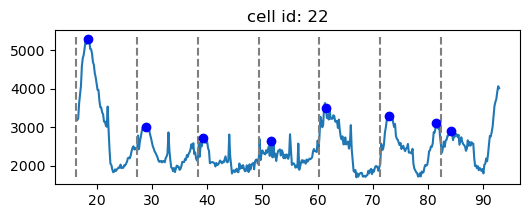

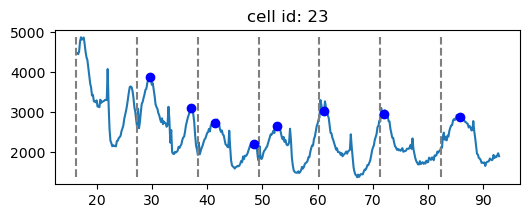

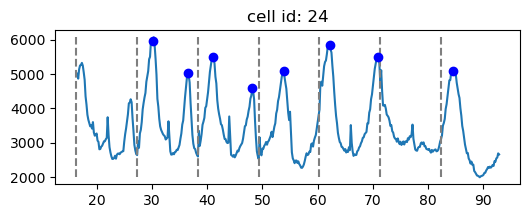

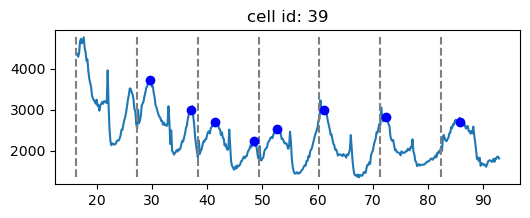

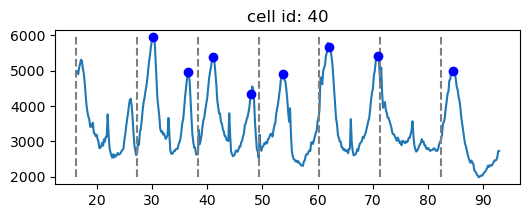

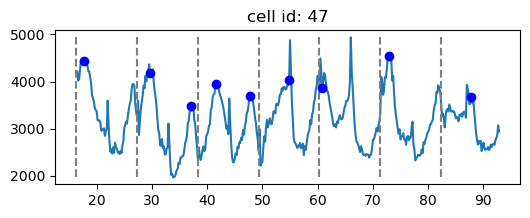

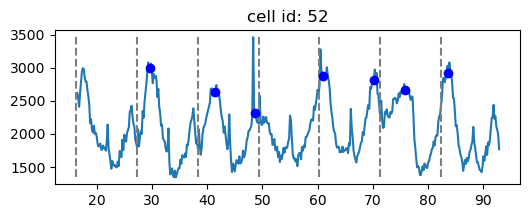

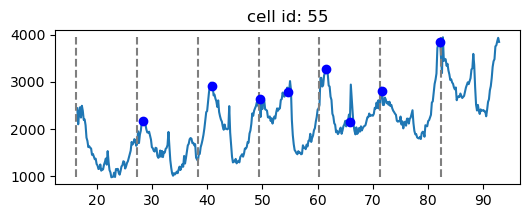

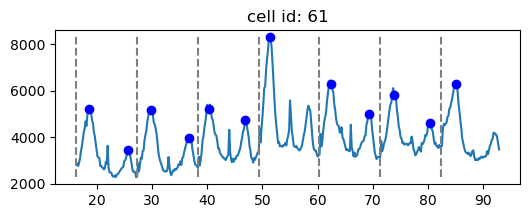

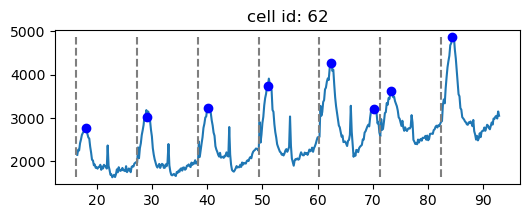

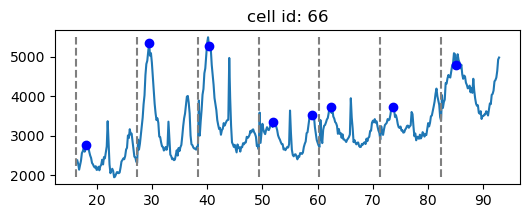

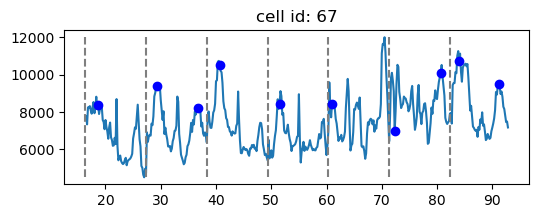

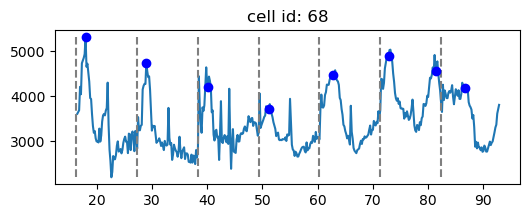

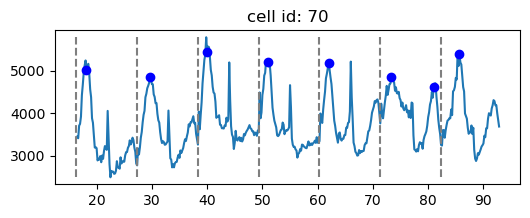

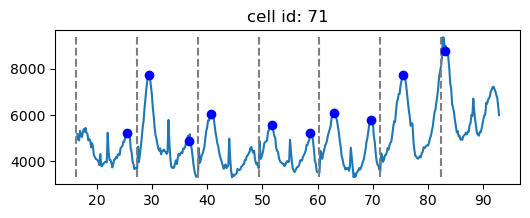

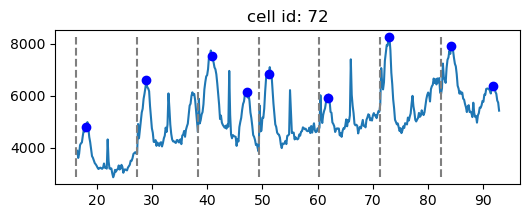

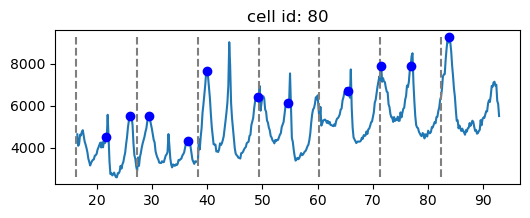

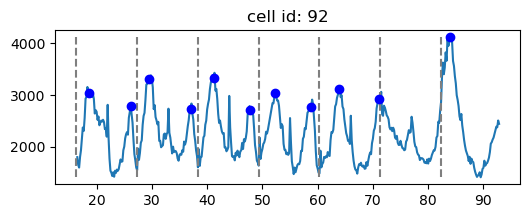

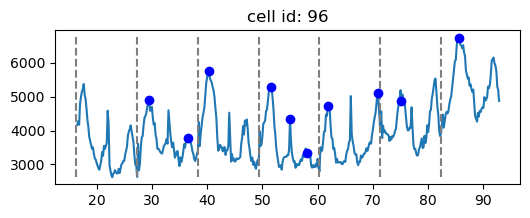

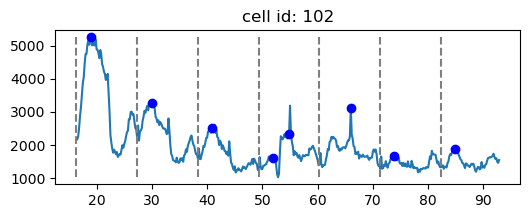

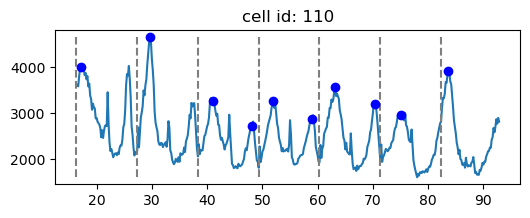

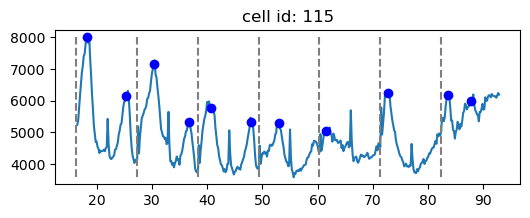

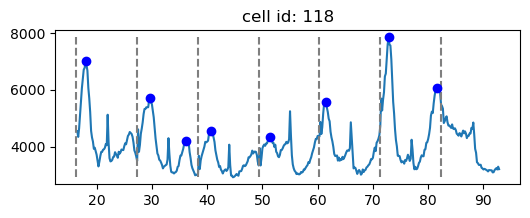

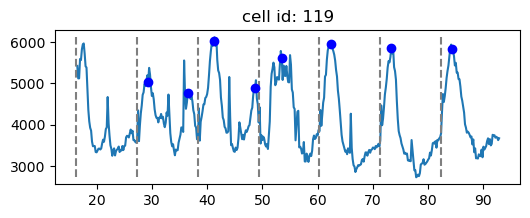

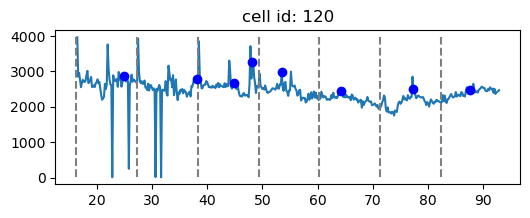

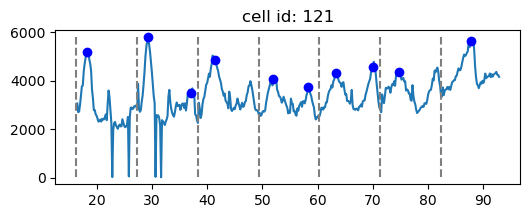

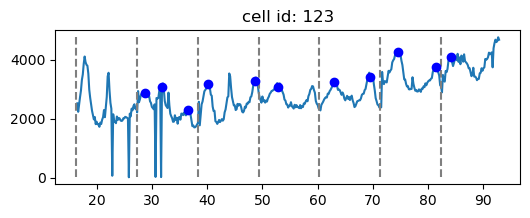

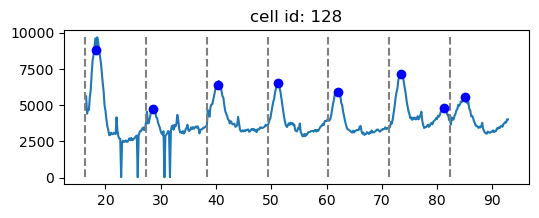

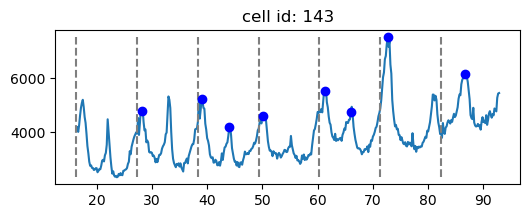

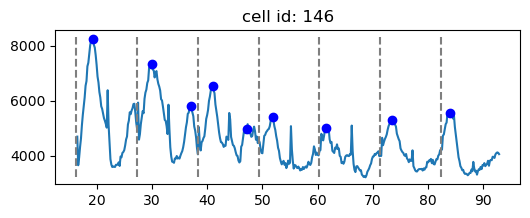

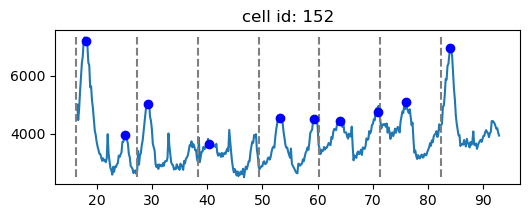

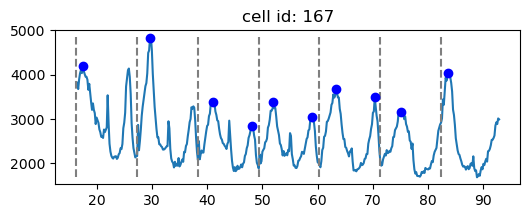

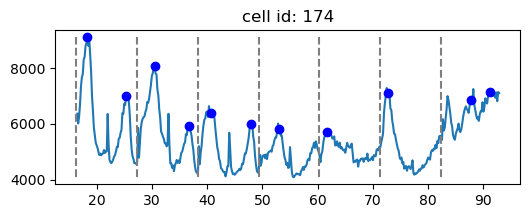

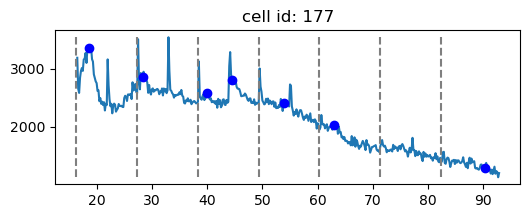

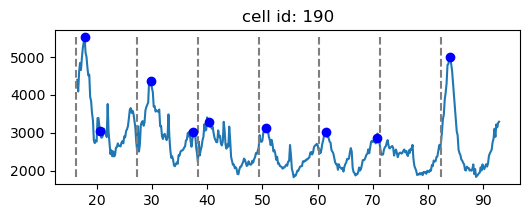

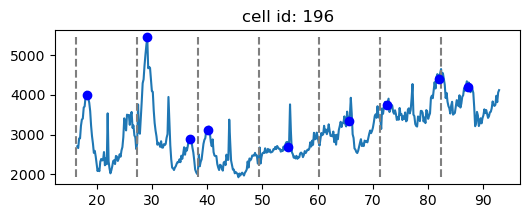

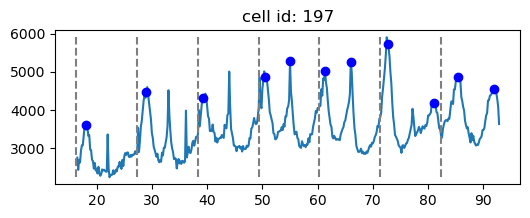

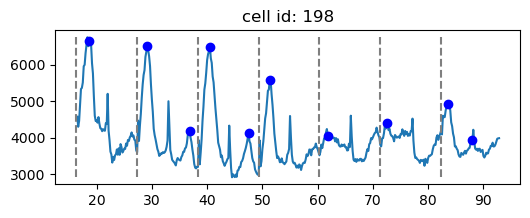

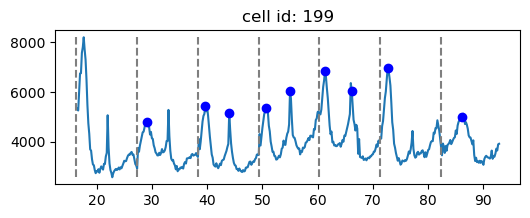

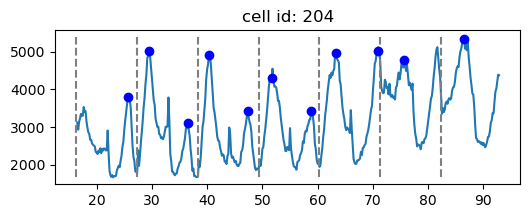

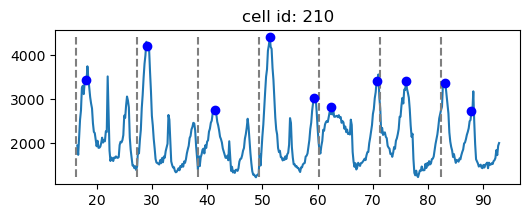

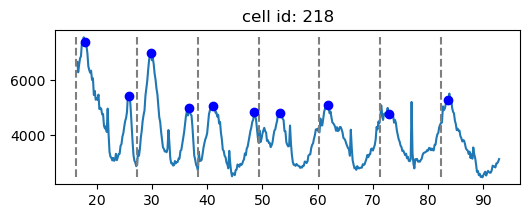

In [554]:
plot_single_cells(dataset, nut_period = 11, 
                  nut_conc = 0.5,
                  smoothed_traces = False,
                  entrain_label = "Unclassified",
                  entrain_mode = "Non-entrained")

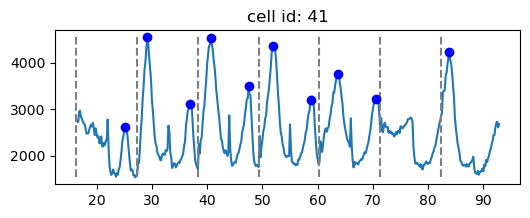

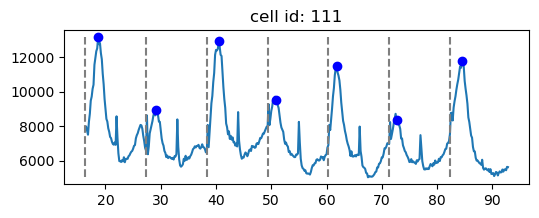

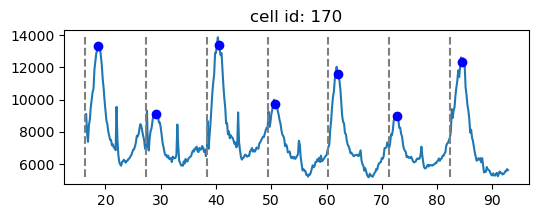

In [633]:
plot_single_cells(dataset, nut_period = 11, 
                  nut_conc = 0.5, 
                  smoothed_traces = False, 
                  entrain_label = "Period-2", 
                  entrain_mode = "Non-entrained")

### Make histogram of unclassified vs entrained

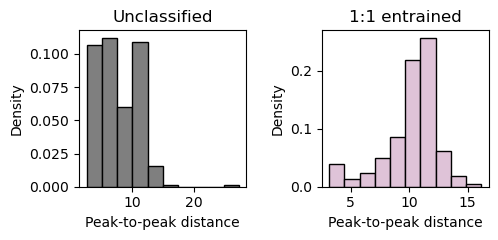

In [583]:
#make_histo_periods_entrained_vs_unclassified(dataset, nut_period=9.17, nut_conc=0.5, entrain_mode= "1.0")
make_histo_periods_entrained_vs_unclassified(dataset, nut_period=11, nut_conc=0.5, entrain_mode= "1.0")

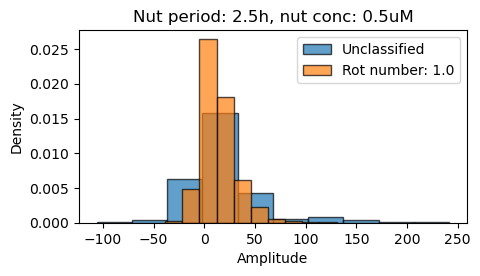

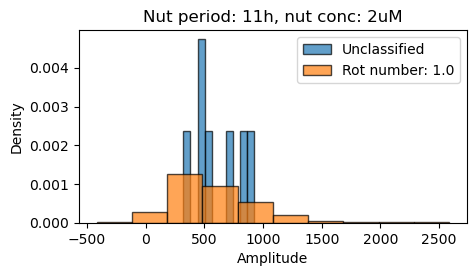

In [480]:
make_histo_amplitudes_entrained_vs_unclassified(dataset, nut_period=2.5, nut_conc=0.5, entrain_mode= "1.0")
make_histo_amplitudes_entrained_vs_unclassified(dataset, nut_period=11, nut_conc=0.5, entrain_mode= "1.0")

Don't see any difference in amplitude distribution :(

In [588]:
rows_cols_unique = find_traces_that_start_together(dataset, 
                                nut_period = 11,
                                nut_conc = 0.5,
                                entrain_label = "Unclassified",
                                entrain_mode = None, 
                                num_traces_to_find = 30, 
                                initial_points_to_compare = 10)

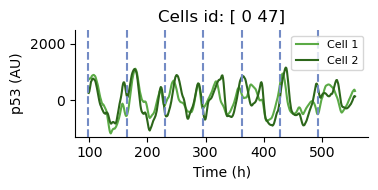

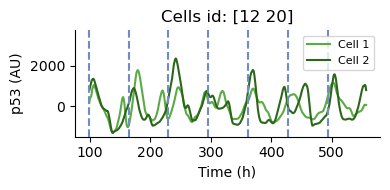

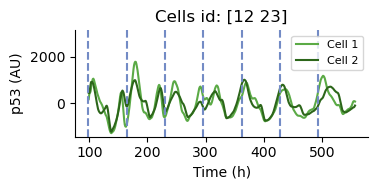

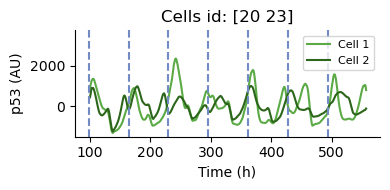

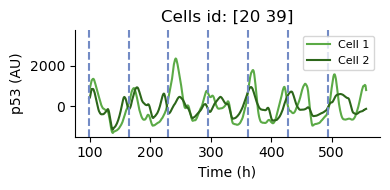

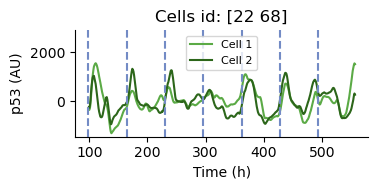

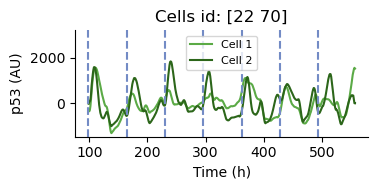

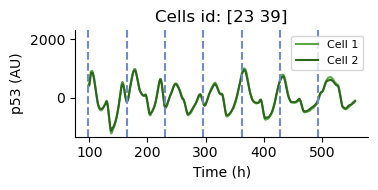

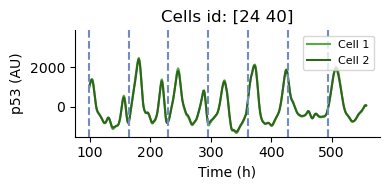

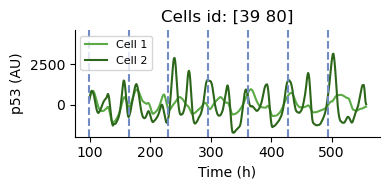

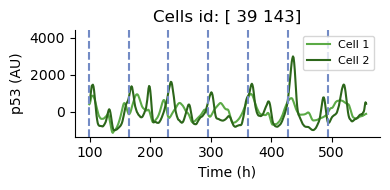

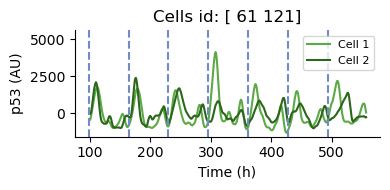

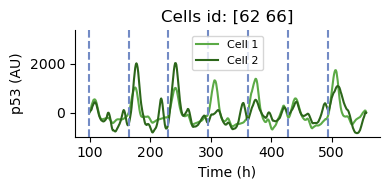

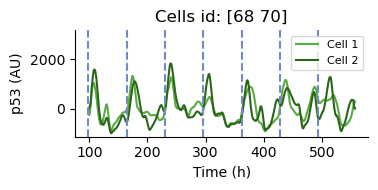

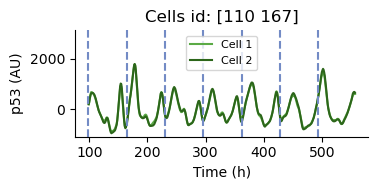

In [590]:
plot_traces_that_start_together(dataset, 
                                rows_cols_unique,
                                nut_period = 11,
                                nut_conc = 0.5)

# PLOTS FOR FIGURE

# Mode hopping

In [614]:
def axis_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

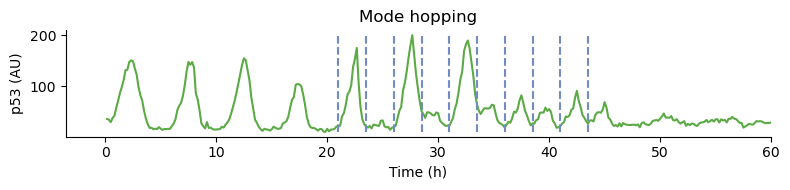

In [628]:
cond1 = dataset["cell_id"]==130
cond2 = dataset["nutlin_period [hour]"]==2.5
cond3 = dataset["nutlin_concentration [uM]"]==0.5
subset = dataset.loc[cond1 & cond2 & cond3].reset_index(drop=True)
pd.set_option('display.max_columns', None)
subset.head()


trace = subset["p53_trace"][0]
time = subset["time"][0]/6
nutlin_pulses = subset["time_nutlin_pulses"][0]/6

fig,ax=plt.subplots(figsize=(8,2))
axis_style(ax)
plt.title("Mode hopping")
plt.plot(time,trace,color="#5BAA46")
plt.vlines(nutlin_pulses, np.min(trace),np.max(trace),linestyle="--",color="#738BC5")
plt.xlabel("Time (h)")
plt.ylabel("p53 (AU)")
plt.xlim(right = 60)
fig.tight_layout()
plt.savefig("Modehopping_25h.svg")
plt.show()

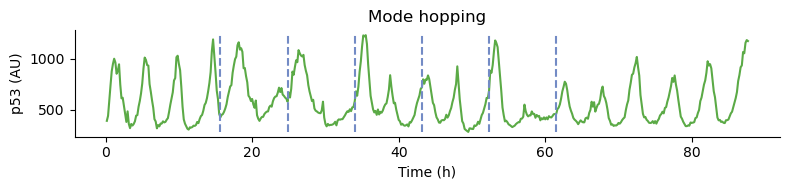

In [625]:
cond1 = dataset["cell_id"]==135
cond2 = dataset["nutlin_period [hour]"]==9.17
cond3 = dataset["nutlin_concentration [uM]"]==0.5
subset = dataset.loc[cond1 & cond2 & cond3].reset_index(drop=True)
pd.set_option('display.max_columns', None)
subset.head()


trace = subset["p53_trace"][0]
time = subset["time"][0]/6
nutlin_pulses = subset["time_nutlin_pulses"][0]/6

fig,ax=plt.subplots(figsize=(8,2))
axis_style(ax)
plt.title("Mode hopping")
plt.plot(time,trace,color="#5BAA46")
plt.vlines(nutlin_pulses, np.min(trace),np.max(trace),linestyle="--",color="#738BC5")
plt.xlabel("Time (h)")
plt.ylabel("p53 (AU)")
fig.tight_layout()
plt.savefig("Modehopping_9h.svg")
plt.show()

# Period 2

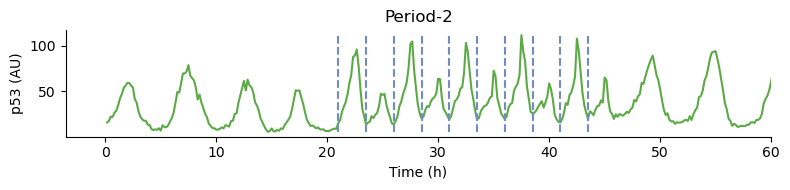

In [631]:
cond1 = dataset["cell_id"]==5
cond2 = dataset["nutlin_period [hour]"]==2.5
cond3 = dataset["nutlin_concentration [uM]"]==0.5
subset = dataset.loc[cond1 & cond2 & cond3].reset_index(drop=True)
pd.set_option('display.max_columns', None)
subset.head()


trace = subset["p53_trace"][0]
time = subset["time"][0]/6
nutlin_pulses = subset["time_nutlin_pulses"][0]/6

fig,ax=plt.subplots(figsize=(8,2))
axis_style(ax)
plt.title("Period-2")
plt.plot(time,trace,color="#5BAA46")
plt.vlines(nutlin_pulses, np.min(trace),np.max(trace),linestyle="--",color="#738BC5")
plt.xlabel("Time (h)")
plt.ylabel("p53 (AU)")
plt.xlim(right = 60)
fig.tight_layout()
plt.savefig("Period2_25h.svg")
plt.show()

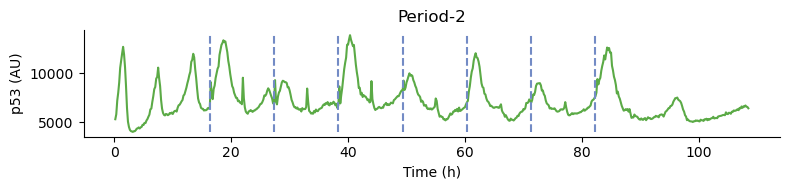

In [636]:
cond1 = dataset["cell_id"]==170
cond2 = dataset["nutlin_period [hour]"]==11
cond3 = dataset["nutlin_concentration [uM]"]==0.5
subset = dataset.loc[cond1 & cond2 & cond3].reset_index(drop=True)
pd.set_option('display.max_columns', None)
subset.head()


trace = subset["p53_trace"][0]
time = subset["time"][0]/6
nutlin_pulses = subset["time_nutlin_pulses"][0]/6

fig,ax=plt.subplots(figsize=(8,2))
axis_style(ax)
plt.title("Period-2")
plt.plot(time,trace,color="#5BAA46")
plt.vlines(nutlin_pulses, np.min(trace),np.max(trace),linestyle="--",color="#738BC5")
plt.xlabel("Time (h)")
plt.ylabel("p53 (AU)")
#plt.xlim(right = 60)
fig.tight_layout()
plt.savefig("Period2_11h.svg")
plt.show()

# Two that looks chaotic in unclassified fraction

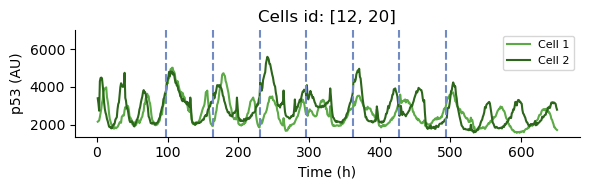

In [641]:
cond1 = dataset["nutlin_period [hour]"] == 11
cond2 = dataset["nutlin_concentration [uM]"] == 0.5
time_nutpeaks_toplot = dataset.loc[cond1 & cond2,"time_nutlin_pulses"].reset_index(drop=True)[0]
time = dataset.loc[cond1 & cond2,"time"].reset_index(drop=True)[0]
couple = [12,20]
#fig, axs = plt.subplots(1,2,figsize=(15,2.5))
fig,ax=plt.subplots(figsize=(6,2))
axis_style(ax)

cond4 = dataset["cell_id"] == couple[0]
trace1 = dataset.loc[cond1 & cond2 & cond4,"p53_trace"].reset_index(drop=True)[0]
cond5 = dataset["cell_id"] == couple[1]
trace2 = dataset.loc[cond1 & cond2 & cond5,"p53_trace"].reset_index(drop=True)[0]
ax.plot(time,trace1, color = "#5BAA46",label="Cell 1")
ax.plot(time,trace2, color = "#2C661A", label = "Cell 2")
(min_y,max_y) = plt.gca().get_ylim()
max_y += 1200
plt.ylim([min_y,max_y])
plt.vlines(time_nutpeaks_toplot, min_y,max_y,linestyle="--",color="#738BC5")
ax.set_xlabel("Time (h)")
ax.set_ylabel("p53 (AU)")
ax.legend(fontsize=8)
ax.set_title("Cells id: "+str(couple))
plt.tight_layout()
plt.savefig("Single_cells_chaos_11h_05uM.svg",transparent=True)
plt.show()


# Two that follows each other in 1:1 entrained fraction

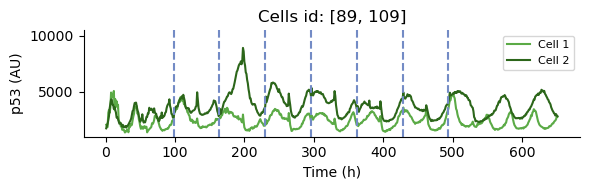

In [644]:
cond1 = dataset["nutlin_period [hour]"] == 11
cond2 = dataset["nutlin_concentration [uM]"] == 0.5
time_nutpeaks_toplot = dataset.loc[cond1 & cond2,"time_nutlin_pulses"].reset_index(drop=True)[0]
time = dataset.loc[cond1 & cond2,"time"].reset_index(drop=True)[0]
couple = [89,109]
#fig, axs = plt.subplots(1,2,figsize=(15,2.5))
fig,ax=plt.subplots(figsize=(6,2))
axis_style(ax)

cond4 = dataset["cell_id"] == couple[0]
trace1 = dataset.loc[cond1 & cond2 & cond4,"p53_trace"].reset_index(drop=True)[0]
cond5 = dataset["cell_id"] == couple[1]
trace2 = dataset.loc[cond1 & cond2 & cond5,"p53_trace"].reset_index(drop=True)[0]
ax.plot(time,trace1, color = "#5BAA46",label="Cell 1")
ax.plot(time,trace2, color = "#2C661A", label = "Cell 2")
(min_y,max_y) = plt.gca().get_ylim()
max_y += 1200
plt.ylim([min_y,max_y])
plt.vlines(time_nutpeaks_toplot, min_y,max_y,linestyle="--",color="#738BC5")
ax.set_xlabel("Time (h)")
ax.set_ylabel("p53 (AU)")
ax.legend(fontsize=8)
ax.set_title("Cells id: "+str(couple))
plt.tight_layout()
plt.savefig("Single_cells_entr_11h_05uM.svg",transparent=True)
plt.show()

# Autocorrelation function

In [ ]:
nut_period = 2.5
nut_conc = 0.5
ind = 0
entrain_label ="Entrained"
entrain_mode = "0.5"

In [ ]:
cond1 = dataset["nutlin_period [hour]"] == nut_period
cond2 = dataset["nutlin_concentration [uM]"] == nut_conc
cond3 = dataset["entrain_label"] == entrain_label
cond4 = dataset["entrain_mode"] == entrain_mode
cond = cond1 & cond2 & cond3 & cond4
data_all = dataset.loc[cond,"trace_zone2_smooth"].reset_index(drop=True)
time_all = dataset.loc[cond,"t2"].reset_index(drop=True)


cell_ids = dataset.loc[cond,"cell_id"].reset_index(drop=True)
data = data_all[np.where(cell_ids == ind)[0]].reset_index(drop=True)[0]
time = time_all[np.where(cell_ids == ind)[0]].reset_index(drop=True)[0]

In [ ]:
trace = data
# Compute the FFT
fft_result = np.fft.fft(trace)
frequencies = np.fft.fftfreq(len(trace))

# Find the index of the maximum amplitude
max_amplitude_index = np.argmax(np.abs(fft_result))
dominant_frequency = frequencies[max_amplitude_index]

# Calculate the period from the dominant frequency
if dominant_frequency != 0:
    period = 1 / np.abs(dominant_frequency)
else:
    period = np.inf

print(f"Dominant Frequency: {dominant_frequency}")
print(f"Estimated Period: {period}")

In [ ]:
time_selected, acorr_selected, peaks_acorr, max_autocorr_T = autocorrelation_function(time, data)

# Set a window size (this determines the size of the intervals)
window_size = int(3*nut_period*6)

# Find preferred lags using sliding windows
preferred_lags = find_preferred_lag(data, window_size)

kde = gaussian_kde(np.array(preferred_lags)/6)
x = np.linspace(min(np.array(preferred_lags)/6), max(np.array(preferred_lags)/6), 1000)

f, [ax1,ax2, ax3] = plt.subplots(1,3,figsize=(10,2.5))
ax1.plot(time-time[0], data)
ax1.set_xlabel("Time (from zone 2)"); ax1.set_ylabel("p53 trace")
ax2.hist(np.array(preferred_lags)/6, density=True) # So that it has units of hours
ax2.plot(x, kde(x))

ax2.set_xlabel("Preferred Lags")
ax2.set_ylabel("pdf")
ax3.plot(time_selected, acorr_selected)
ax3.set_xlabel("Lags")
ax3.set_ylabel("Autocorrelation function")
ax3.scatter(time_selected[peaks_acorr],acorr_selected[peaks_acorr])
ax3.set_title("Peaks at lag: "+str(max_autocorr_T))
plt.tight_layout()
plt.show()

In [ ]:
from scipy.fft import fft, ifft, fftfreq
# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
yf = fft(data)
xf = fftfreq(N, T)[:N//2]
xf = fftfreq(N, T)[:N//2]
plt.plot(1/xf, 2.0/N * np.abs(yf[0:N//2]))
